# Basketball Analytics Predictive Modeling

After the data engineering step, we can start modeling.
In the previous step we reformated the data from ball touch level to ball possession level. The goal is to build a model to predict wehther a ball possession ends with a shot attempt from the presence of defensive plays. After building the model we can use feature importance to generate defensive player ranking. The idea is that players that make more important defensive plays often are ranked higher. The defensive ranking is a weighted average of the defensive plays they make.

We can use any predictive model that can give us a measure of feature importance. For our caase logistic regression is used and variable coefficients are used as feature importance (we can do that in this case since our features are normalized).

Let's load the data from the data engineering step

In [ ]:
pacman::p_load(dplyr,readr, FactoInvestigate, Factoshiny, DT, corrplot, rio, FactoMineR, tidyr, shiny, lubridate, broom)
 
library(ggfortify)
library(ggplot2)
library(grid)
library(jpeg)
library(cluster) 
library(factoextra)
library(glmnet)
library(pROC)
library(dplyr)

options(warn=-1)


# Restore the object
touch_data_aggregate=readRDS(file = "my_data_with_18_cluster_features.rds")


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-2

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Remove chance_id variable as it's not needed now

In [40]:
touch_data_aggregate_plays=subset(touch_data_aggregate,select=-c(chance_id))

Create a sum variable per ball possession. It simply counts the number of ball touches per possession

In [41]:
touch_data_aggregate_plays$sum=rowSums(subset(touch_data_aggregate_plays,select=-shot),na.rm=TRUE)
touch_data_aggregate_plays[is.na(touch_data_aggregate_plays)] = 0

Filter ball possesions that have at least two ball touches and set all variables that are more than 1 to 1. This is a simple way to do normalization as are features now are either 0 or 1

In [42]:
touch_data_aggregate_plays=touch_data_aggregate_plays %>% filter(sum>1)
touch_data_aggregate_plays[touch_data_aggregate_plays>1]=1

Now we are ready to build the logistic regressin model. sum variable is removed and train and test sets are created

In [49]:
comb_shot_tr=subset(touch_data_aggregate_plays,select=-sum)

trPerc = 0.7
sp = sample(1:nrow(comb_shot_tr),as.integer(trPerc*nrow(comb_shot_tr)))
## division in two samples
tr = comb_shot_tr[sp,]
ts = comb_shot_tr[-sp,]

A simple unregularized logistic regression model is created

In [ ]:
model <- glmnet(subset(tr,select=-shot), tr$shot, alpha = 0, family = "binomial",
                lambda = 0)

In [ ]:
x.test <- model.matrix(shot ~., ts)[,-1]
probabilities <- model %>% predict(newx = x.test)


ts$prob=probabilities

g <- roc(shot ~ prob, data = ts)
plot(g)

Aunder=auc(g)
Aunder

In [ ]:
def_plays_imp=as.data.frame(as.matrix(coef(model)))
def_plays_imp$def_play=rownames(def_plays_imp)
rownames(def_plays_imp)=NULL
colnames(def_plays_imp)=c("coef","def_play")

def_plays_imp=def_plays_imp[-1,]
def_plays_imp=def_plays_imp %>% arrange(coef)

In [ ]:
saveRDS(def_plays_imp, file = "def_plays_imp.rds")

### Apendix

In [7]:
library('pROC')

prob=predict(log_fit,ts,type=c("response"))

ts$prob=prob

g <- roc(shot ~ prob, data = ts)
plot(g)

Aunder=auc(g)
Aunder

ERROR: Error in predict(log_fit, ts, type = c("response")): object 'log_fit' not found


#### Naive Bayes

In [38]:
nb_fit=naiveBayes(shot~.,data=train)
prob=predict(nb_fit,test,type="raw")



Setting levels: control = 0, case = 1

Setting direction: controls > cases



Area under the curve: 0.5966

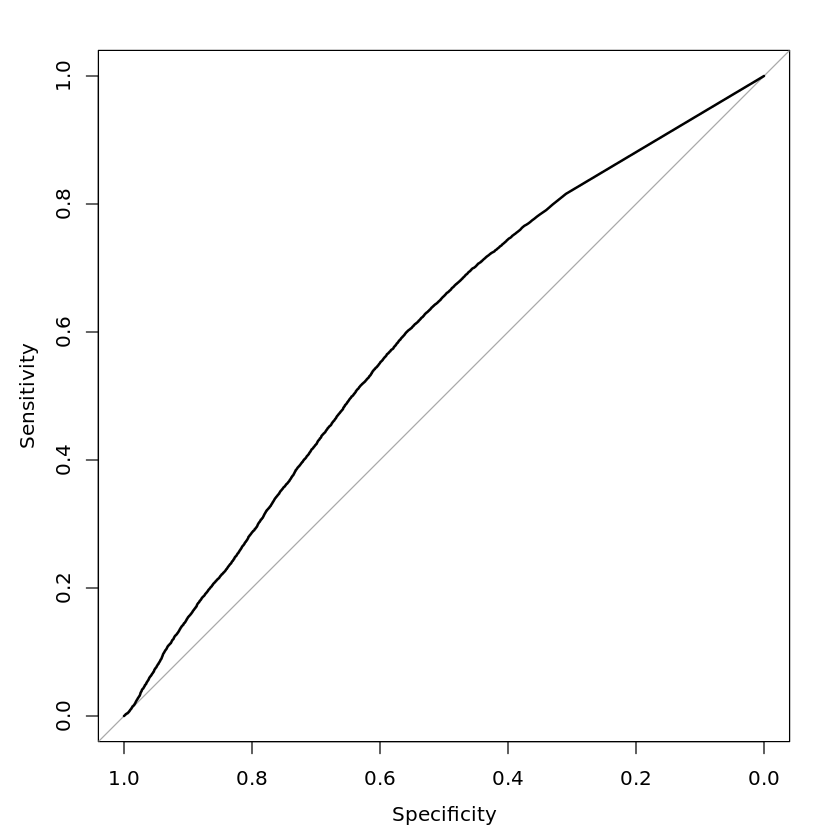

In [39]:
test$prob=prob[,1]
g <- roc(shot ~ prob, data = test)
plot(g)

Aunder=auc(g)
Aunder


#### Random Forest

In [ ]:
classifier_RF = randomForest(x = train[1:521],
                             y = train$shot,
                             ntree = 500)

#### xgboost

In [86]:
xgboost_fit=xgboost(data=data.matrix(train[,1:630]),booster="gblinear",label=train$shot,max_depth=6,objective="binary:logistic",nrounds=100)

[14:54:05] WARNING: amalgamation/../src/learner.cc:627: 
Parameters: { "max_depth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[1]	train-logloss:0.469658 
[2]	train-logloss:0.457241 
[3]	train-logloss:0.454847 
[4]	train-logloss:0.454174 
[5]	train-logloss:0.453970 
[6]	train-logloss:0.453895 
[7]	train-logloss:0.453858 
[8]	train-logloss:0.453833 
[9]	train-logloss:0.453813 
[10]	train-logloss:0.453796 
[11]	train-logloss:0.453781 
[12]	train-logloss:0.453767 
[13]	train-logloss:0.453755 
[14]	train-logloss:0.453745 
[15]	train-logloss:0.453735 
[16]	train-logloss:0.453727 
[17]	train-logloss:0.453719 
[18]	train-logloss:0.453712 
[19]	train-logloss:0.453706 
[20]	train-logloss:0.453701 
[21]	train-logloss:0.453696 
[22]	train-logloss:0.453692

In [87]:
tsx=as.matrix(test[,1:630])
prob=predict(xgboost_fit,tsx)
prob=as.data.frame(prob)
ts=as.data.frame(test)

ts=cbind(ts,prob)

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.6167

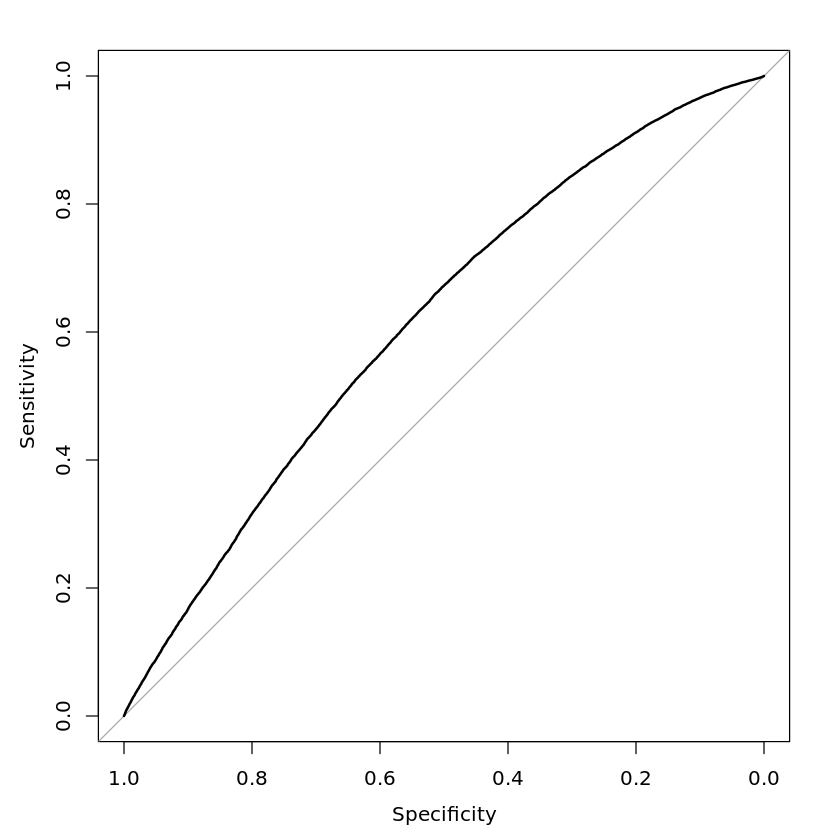

In [88]:
g <- roc(shot ~ prob, data = ts)
plot(g)

Aunder=auc(g)
Aunder